### Case Study:  Bird Migration

The global positioning system, or GPS, provides location information
anywhere on earth. GPS is used for various different purposes,
ranging from commercial to military applications.
One interesting area of research uses GPS to track movements of animals. It is now possible to manufacturer a small GPS device that is solar charged, so you don't need to change batteries, and use it to track flight patterns of birds.

In this case study it will be shown how to manipulate, examine and visualize GPS data used to tracking birds. The data is referent to three diferent birds (Eric, Sanne, Nico), provided by the LifeWatch INBO project.

 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
birds_data = pd.read_csv('bird_tracking.csv')
birds_data.head()

,Unnamed: 0,altitude,date_time,device_info_serial,direction,latitude,longitude,speed_2d,bird_name
0,0,71,2013-08-15 00:18:08+00,851,-150.469753,49.419860,2.120733,0.150000,Eric
1,1,68,2013-08-15 00:48:07+00,851,-136.151141,49.419880,2.120746,2.438360,Eric
2,2,68,2013-08-15 01:17:58+00,851,160.797477,49.420310,2.120885,0.596657,Eric
3,3,73,2013-08-15 01:47:51+00,851,32.769360,49.420359,2.120859,0.310161,Eric
4,4,69,2013-08-15 02:17:42+00,851,45.191230,49.420331,2.120887,0.193132,Eric


In [3]:
birds_data.altitude.max() , birds_data.speed_2d.max()

(6965, 63.4880658076776)

The data also contain estimates of two dimensional speeds of the birds. That is how fast they were flying on a 2D plane that is a local approximation to the curved surface of the earth. Let's look at the Eric's speed data in a little bit more detail.

In [4]:
speed = birds_data.speed_2d[birds_data.bird_name == 'Eric']
speed

0        0.150000
1        2.438360
2        0.596657
3        0.310161
4        0.193132
           ...   
19790    0.064031
19791    1.942395
19792    1.678392
19793    0.208087
19794    0.056569
Name: speed_2d, Length: 19795, dtype: float64

In [5]:
#checking for NaN values
np.isnan(speed).any(), np.sum(np.isnan(speed))

(True, 85)

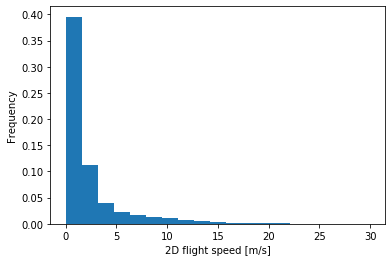

In [6]:
#plotting excluding NaN, with normed values
ind = np.isnan(speed)
plt.hist(speed[~ind], np.linspace(0, 30, 20), density=True)
plt.xlabel('2D flight speed [m/s]')
plt.ylabel('Frequency');

- Let's calculate the daily mean speed of Eric, from timestamps, using datetime module.

In [8]:
timestamps = []

for k in range(len(birds_data)):
    timestamps.append(datetime.datetime.strptime(
        birds_data.date_time[k][:-3], "%Y-%m-%d %H:%M:%S"))

In [9]:
timestamps[:3]

[datetime.datetime(2013, 8, 15, 0, 18, 8),
 datetime.datetime(2013, 8, 15, 0, 48, 7),
 datetime.datetime(2013, 8, 15, 1, 17, 58)]

In [10]:
birds_data["timestamp"] = pd.Series(timestamps, index= birds_data.index)

In [11]:
birds_data[:3]

,Unnamed: 0,altitude,date_time,device_info_serial,direction,latitude,longitude,speed_2d,bird_name,timestamp
0,0,71,2013-08-15 00:18:08+00,851,-150.469753,49.41986,2.120733,0.150000,Eric,2013-08-15 00:18:08
1,1,68,2013-08-15 00:48:07+00,851,-136.151141,49.41988,2.120746,2.438360,Eric,2013-08-15 00:48:07
2,2,68,2013-08-15 01:17:58+00,851,160.797477,49.42031,2.120885,0.596657,Eric,2013-08-15 01:17:58


In [12]:
times = birds_data.timestamp[birds_data.bird_name == 'Eric']
elapsed_time = [time - times[0] for time in times]

E.g: time between the 1st and the 100th observation?

In [13]:
elapsed_time[100] - elapsed_time[0]

Timedelta('1 days 05:24:41')

Or in a day scale format, until 1000th:

In [14]:
(elapsed_time[1000] - elapsed_time[0]) / datetime.timedelta(days = 1)

12.084722222222222

Let's inspect more visually the time elapsed throughout the observations. If the time that the observations took place were equally distributed, we would see a straight line.
The jumps in the curve simbolize observations that are further apart from one another than the other observations in the dataset. The last trace with higher inclination indicates a greater gradient which means that observation per time ratio have increased.

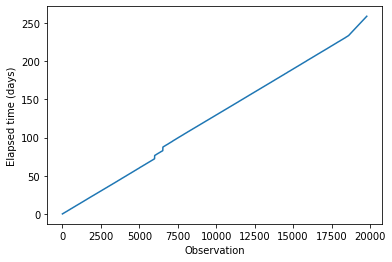

In [15]:
plt.plot(np.array(elapsed_time) / datetime.timedelta(days=1))
plt.xlabel("Observation")
plt.ylabel("Elapsed time (days)");

Finally calculating the Eric mean daily speed:

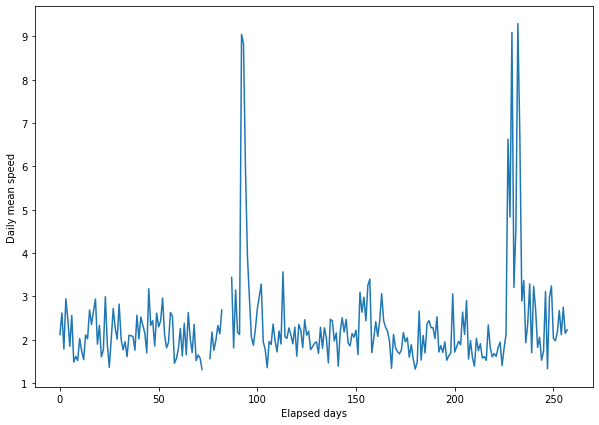

In [16]:
data = birds_data[birds_data.bird_name == 'Eric']
times = data.timestamp

elapsed_time = [time - times[0] for time in times]
elapsed_days = np.array(elapsed_time) / datetime.timedelta(days=1)

next_day = 1
inds=[]
daily_mean_speed=[]
for i,d in enumerate(elapsed_days):
    if d < next_day:
        inds.append(i)
    else:
        daily_mean_speed.append(np.mean(data.speed_2d[inds]))
        next_day += 1
        inds = []

plt.figure(figsize=(10,7))    
plt.plot(daily_mean_speed)
plt.xlabel("Elapsed days")
plt.ylabel("Daily mean speed")
plt.savefig("mean_daily_speed.pdf")

The idea was to go through the records inspecting the observations that happened in the same day, saving their speed values, and when it jumped to the next day, calculate that previously saved values mean (excluding the one of the new day obviously), and reset the procedure on and on.

Note: ofc there are several ways to achieve this. In particular this procedure is not the quickest one (as we will see), but it is fun.

- Let's analyze the trajectories:

Checking the Eric's trajectory:

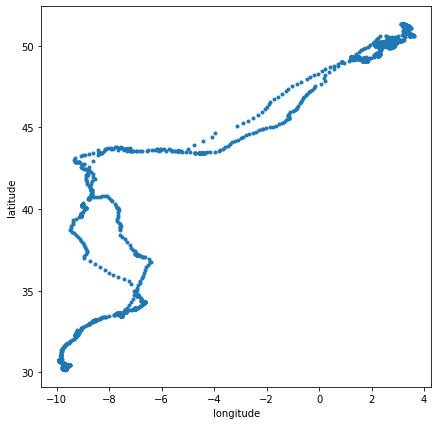

In [17]:
ix = birds_data.bird_name == "Eric"
x, y = birds_data.longitude[ix], birds_data.latitude[ix]

plt.figure(figsize=(7,7))
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.plot(x, y, ".");

All the birds trajectories:

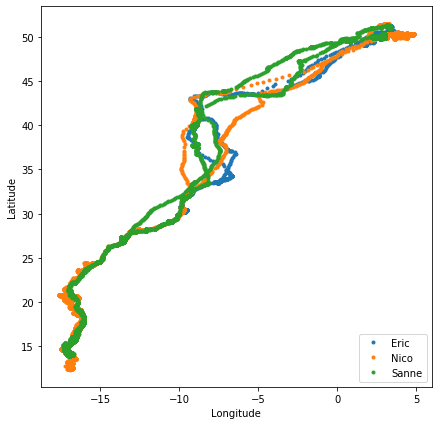

In [18]:
birds_names = pd.unique(birds_data.bird_name)

plt.figure(figsize=(7,7))    
for bird in birds_names:
    ix = birds_data.bird_name == bird
    x, y = birds_data.longitude[ix], birds_data.latitude[ix]
    plt.plot(x, y, ".", label= bird)
    
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend(loc = 'lower right');

Cartopy is a Python package designed for geospatial data processing in order to produce maps and other geospatial data analyses.
Let's make use of its functionalities:

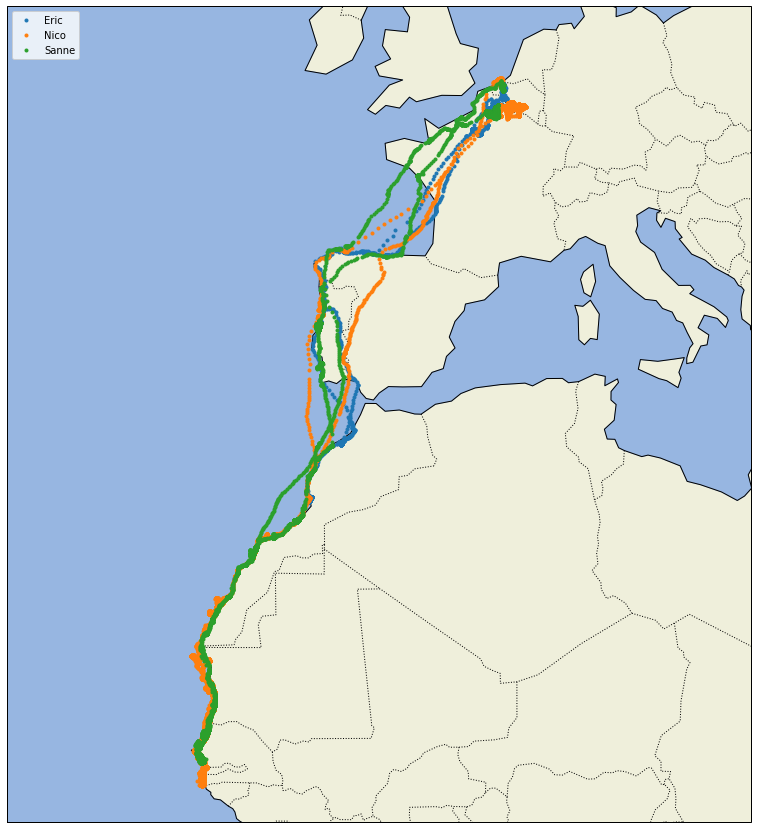

In [19]:
proj = ccrs.Mercator()

plt.figure(figsize=(15,15))
ax = plt.axes(projection = proj)
ax.set_extent((-30.0, 20.0, 52.0, 10.0))
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')

for name in birds_names:
    ix = birds_data.bird_name == name
    x, y = birds_data.longitude[ix], birds_data.latitude[ix]
    ax.plot(x, y, '.', transform = ccrs.Geodetic(), label=name)
    
plt.legend(loc="upper left")
plt.savefig("map.pdf")

- Let's see how could we calculalte the birds daily average speed differently from before.

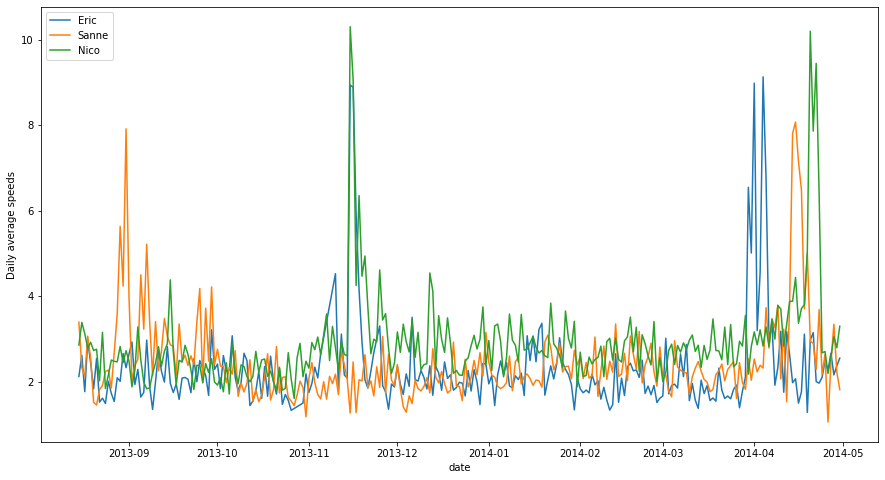

In [20]:
grouped_birds = birds_data.groupby(['bird_name'])

birds_data.date_time = pd.to_datetime(birds_data.date_time)
birds_data["date"] = birds_data["date_time"].dt.date

grouped_birdday = birds_data.groupby(["bird_name", 'date'])

mean_speed_perday = grouped_birdday.speed_2d.mean()

eric_daily_speed  = mean_speed_perday['Eric']
sanne_daily_speed = mean_speed_perday['Sanne']
nico_daily_speed  = mean_speed_perday['Nico']


plt.figure(figsize=(15,8))
plt.ylabel('Daily average speeds')
eric_daily_speed.plot(label="Eric")
sanne_daily_speed.plot(label="Sanne")
nico_daily_speed.plot(label="Nico")
plt.legend(loc="upper left")
plt.show()

- Let's plot the birds altitude daily average as well

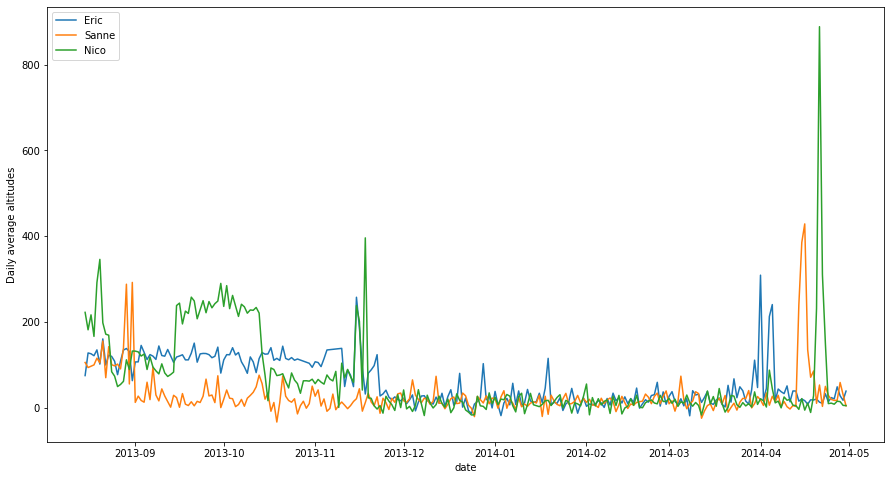

In [21]:
mean_altitudes_perday =  grouped_birdday.altitude.mean()
mean_altitudes_perday

eric_daily_altitude  = mean_altitudes_perday['Eric']
sanne_daily_altitude = mean_altitudes_perday['Sanne']
nico_daily_altitude  = mean_altitudes_perday['Nico']


plt.figure(figsize=(15,8))
plt.ylabel('Daily average altitudes')
eric_daily_altitude.plot(label="Eric")
sanne_daily_altitude.plot(label="Sanne")
nico_daily_altitude.plot(label="Nico")
plt.legend(loc="upper left")
plt.show()

In [22]:
mean_speeds = grouped_birds.speed_2d.mean()
max_speeds = grouped_birds.speed_2d.max()
max_altitudes = grouped_birds.altitude.max()

dic_table = {'mean_speed': [mean_speeds[0],mean_speeds[1],mean_speeds[2]], 
      'max_speed': [max_speeds[0], max_speeds[1], max_speeds[2]], 
      'max_altitude': [max_altitudes[0], max_altitudes[1], max_altitudes[2]]}

table = pd.DataFrame.from_dict(dic_table)
table.index = ["Eric", "Sanne", "Nico"]
table

,mean_speed,max_speed,max_altitude
Eric,2.300545,63.488066,4808
Sanne,2.908726,48.381510,6965
Nico,2.450434,57.201748,6145


Although rare, there are species that can fly over 6000m, commonly during migration.